In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
from matplotlib import lines
import pickle as pkl
from utils import u_plot as uplot, constants as cnst, u_darrays, u_met
import pandas as pd
import os
from utils import u_statistics as u_stat
import glob
import matplotlib as mpl

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd /home/ck/pythonWorkspace/proj_CEH/

/home/ck/pythonWorkspace/proj_CEH


In [3]:
def linear_trend_lingress(x, nb_missing=None, sig=None):
    
    
    coll = []
    for xx in x.transpose():

        slope, intercept, r, p, std_err = stats.linregress(np.arange(len(xx.values)), xx.values)

        # we need to return a dataarray or else xarray's groupby won't be happy

        if nb_missing is not None:
            if np.nansum(xx.values==0)>=10:
                p = np.nan
                slope = np.nan
        
        if sig is not None:
            if p > sig:
                slope = np.nan
        
        coll.append(slope)
    
    return xr.DataArray(coll,)

In [4]:
def linear_trend_lingress_2d(x, nb_missing=None, sig=None, method=None):
    
    
    # stack lat and lon into a single dimension called allpoints
    datastacked = x.stack(allpoints=['latitude', 'longitude'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_lingress,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = np.nan
            
    return dtrend['slope']

In [5]:
filepath  = cnst.network_data + 'data/CLOVER/chris_input/'
file = filepath + 'zonal_mean_10W_10E_trend_1deg_70C_GridSat_cdr_1800_monthly.gra'

In [6]:
file

'/home/ck/DIR/cornkle/data/CLOVER/chris_input/zonal_mean_10W_10E_trend_1deg_70C_GridSat_cdr_1800_monthly.gra'

In [7]:
def readFile(bfile, nx, ny, nz,nt, nvars): #1,72,2,12,5
    if not os.path.isfile(bfile):
        return np.array([False])
    
    rrShape = (nt, nz, ny, nx, nvars)  # msg shape
    rrMDI = np.float32(13.5)#rrMDI = np.uint8(255)
    rr = np.fromfile(bfile, dtype=rrMDI.dtype)
    
    rr.shape = rrShape
    ipdb.set_trace()
    msg_latlon = np.load(llfile)

    mlon = msg_latlon['lon']
    mlat = msg_latlon['lat']

    msg_obj = {'t': rr, 'lons': mlon, 'lats': mlat}  # lats lons numpy arrays!

    return msg_obj

In [8]:
arr = np.array([12,5,2,72])  # read chris MCS trend file month, variable, MCS type, latitude (-34.5, 1deg steps)
rrMDI = np.float32(13.5)#rrMDI = np.uint8(255)
rr = np.fromfile(file, dtype=rrMDI.dtype)
rr.shape = tuple(arr)
rr[rr<-900] = np.nan
tgrad = rr[:,1,0,:]*10
tmean = rr[:,2,0,:]
ttest = rr[:,4,0,:]

In [9]:
ttest = xr.DataArray(ttest.T, coords={'lat' :  np.arange(-34.5,-34.5+72*1,1), 'month' : np.arange(1,13,1) }, dims=['lat', 'month'])

In [10]:
da = xr.DataArray(tgrad.T, coords={'lat' :  np.arange(-34.5,-34.5+72*1,1), 'month' : np.arange(1,13,1) }, dims=['lat', 'month'])

In [11]:
mean = xr.DataArray(tmean.T, coords={'lat' :  np.arange(-34.5,-34.5+72*1,1), 'month' : np.arange(1,13,1) }, dims=['lat', 'month'])

In [12]:
da = da.where(ttest.values>=1.697)  # p < 0.05, 5000km2 MCS -70C

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


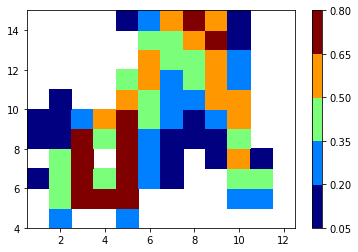

In [13]:
f = plt.figure()
ax = f.add_subplot(111)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), np.arange(4,16,1),da.sel(lat=slice(4,15)).values,cmap=cmapp, vmin=0.05, vmax=0.80)
cbar = f.colorbar(mappable, ticks=np.linspace(0.05,0.80,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')
# -70 MCS >25000km2 trends 

In [14]:
da.sel(lat=slice(4,15)).shape

(11, 12)

In [15]:
era_srfc = xr.open_dataset(cnst.ERA_MONTHLY_SRFC)
era_pl = xr.open_dataset(cnst.ERA_MONTHLY_PL)
ccover = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count.nc')

In [16]:
era_srfc = u_darrays.flip_lat(era_srfc)
era_pl = u_darrays.flip_lat(era_pl)

In [17]:
# ws_ar = u_met.u_v_to_ws_wd(era_pl['u'].values, era_pl['v'].values)
# era_pl['v'].values = ws_ar[0]

era_trend = era_pl.sel(longitude=slice(-10,10), latitude=slice(0,25)).squeeze().mean('longitude')
ccover_trend = ccover['tir'].sel(lon=slice(-10,10), lat=slice(0,25)).squeeze().sum('lon')

In [18]:
def stddev(data):

    bla = np.std(data.values) #/np.mean(data.values)

    return xr.DataArray(bla,)

In [19]:
utrend = era_trend['u'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10

vtrend = era_trend['v'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10

qtrend = era_trend['q'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10, sig=0.05)*10*1000

qtrend_ns = era_trend['q'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10*1000

ttrend = era_trend['t'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10

shear_u = era_trend['u'][era_trend['time.year']>1982].sel(level=slice(600,925)).min(dim='level')-era_trend['u'].sel(level=slice(600,925)).max(dim='level')
shear_v = era_trend['v'][era_trend['time.year']>1982].sel(level=slice(600,925)).min(dim='level')-era_trend['v'].sel(level=slice(600,925)).max(dim='level')
ws_shear = u_met.u_v_to_ws_wd(shear_u.values, shear_v.values)
shear = era_trend['u'][era_trend['time.year']>1982].sel(level=925)
shear.name = 'shear'
shear.values = ws_shear[0]
strend_ns = shear.squeeze().groupby('time.month').apply(linear_trend_lingress,nb_missing=10)*10

ctrend = ccover_trend.groupby('time.month').apply(linear_trend_lingress,nb_missing=10, sig=0.05)*10

In [20]:
np.unique((era_trend['t']['time.year']))

array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017])

In [21]:
ctrend

<xarray.DataArray (month: 12, dim_0: 358)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: dim_0

In [22]:
umean = era_trend['u'][era_trend['time.year']>1982].sel(level=slice(600,700)).mean(dim='level').squeeze().groupby('time.month').mean('time')
vmean = era_trend['v'][era_trend['time.year']>1982].sel(level=slice(600,700)).mean(dim='level').squeeze().groupby('time.month').mean('time')
u9mean = era_trend['u'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month').mean('time')
qmean = era_trend['q'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month').mean('time')
tmean = era_trend['t'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month').mean('time')
shearmean = shear[shear['time.year']>1982].squeeze().groupby('time.month').mean('time') #(u9mean/(umean-u9mean))*100

In [23]:
cmean = ccover_trend.groupby('time.month').mean('time')

In [24]:
strend_ns

<xarray.DataArray (month: 12, dim_0: 34)>
array([[ 0.242317,  0.163738,  0.115612, ..., -0.596722, -0.510645, -0.413861],
       [ 0.539225,  0.516727,  0.506733, ...,  0.538344,  0.549707,  0.532244],
       [ 0.571489,  0.541153,  0.520407, ..., -0.238378, -0.209663, -0.156098],
       ...,
       [ 0.227149,  0.116707, -0.008091, ..., -0.085521, -0.119048, -0.133166],
       [ 0.016176, -0.074351, -0.159531, ...,  0.296891,  0.34628 ,  0.403035],
       [ 0.291808,  0.242843,  0.164769, ...,  0.06197 ,  0.133098,  0.219687]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: dim_0

In [25]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, x, y, title=None,  mask_sig=None, quiver=None, contour=None, contour2=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111)  # this opens a new plot axis
    mapp = ax.contourf(x, y, data, **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(x, y, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
                        cmap=contour['cmap'] ) 
        
        plt.clabel(cs, inline=1, fontsize=10)
        
    ## additional contour on plot   
    if contour2 is not None:
        cs = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], 
                        cmap=contour2['cmap'] ) 
        
        plt.clabel(cs, inline=1, fontsize=10)
        
    plt.title(title)
    # Countries
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

In [26]:
contour = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : qtrend.transpose(), 
           'levels' : [0.1,0.2,0.3], 'cmap' : 'viridis'}
contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : strend_ns.transpose(), 
           'levels' : np.linspace(-0.5,0.5,8), 'cmap' : 'Greys'}

mask_sig = (qtrend.transpose()>0.2).astype(int) 

In [27]:
mcs = cnst.GRIDSAT + 'aggs/box_13W-13E-4-8N_meanT-50_from5000km2.nc'

In [28]:
mcs_temp = xr.open_dataset(mcs)

In [29]:
mcs_temp

<xarray.Dataset>
Dimensions:  (time: 420)
Coordinates:
  * time     (time) datetime64[ns] 1983-01-31 1983-02-28 ... 2017-12-31
Data variables:
    tir      (time) float64 ...

In [119]:
def calc_month(m):
    srfc = cnst.ERA_MONTHLY_SRFC
    pl = cnst.ERA_MONTHLY_PL
    mcs = cnst.GRIDSAT + 'aggs/box_13W-13E-4-8N_meanT-50_from5000km2.nc'
    if (m <= 6) | (m >= 10):
        box = [-10,10,5,8]
    else:
        box =[-10,10,8,18]
    #tpick = [-10,10,6,26]
    Tlons = [-10,10]

    dam = xr.open_dataset(srfc)
    dam = u_darrays.flip_lat(dam)
    dam = dam['t2m']

    da = xr.open_dataset(pl)
    da = u_darrays.flip_lat(da)
    da_movshear = da.sel(longitude=slice(box[0], box[1]), latitude=slice(3,20))
    da = da.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))#latitude=slice(36, -37))
    

    u925 = da['u'].sel(level=slice(825, 925)).mean(dim='level')#).mean(dim='level')  #slice(850
    u600 = da['u'].sel(level=slice(600, 700)).mean(dim='level')
    u600_mov =  da_movshear['u'].sel(level=slice(600, 700)).mean(dim='level')
    
    v925 = da['v'].sel(level=slice(825, 925)).mean(dim='level')#).mean(dim='level')  #slice(850
    v600 = da['v'].sel(level=slice(600, 700)).mean(dim='level')

    qq925 = da['q'].sel(level=slice(825,925)).mean(dim='level')
    qq600 = da['q'].sel(level=slice(600, 700)).mean(dim='level')

    mcs_temp = xr.open_dataset(mcs)
    mcs_temp = mcs_temp['tir']
    months = [1,2,3,4,5,6,7,8,9,10,11,12]
    mnames = {1:'Jan',2:'Feb', 3 : 'Mar', 4 : 'April', 5 : 'May', 6:'Jun', 7:'Jul', 8:'Aug', 9 : 'Sep', 10 : 'Oct', 11:'Nov', 12:'Dec'}

    tsouth = dam.sel(longitude=slice(Tlons[0], Tlons[1]), latitude=slice(4,8))
    tnorth = dam.sel(longitude=slice(Tlons[0], Tlons[1]), latitude=slice(12,32))

    south = tsouth[(tsouth['time.month']==m)]
    north = tnorth[(tnorth['time.month']==m)]
    ulow = u925[(u925['time.month']==m)]
    uhigh = u600[(u600['time.month']==m)]
    uhigh_mov = u600_mov[(u600_mov['time.month']==m)]
    vlow = v925[(v925['time.month']==m)]
    vhigh = v600[(v600['time.month']==m)]
    mcs_month = mcs_temp[mcs_temp['time.month']==m]#*(-1)
    qlow = qq925[(qq925['time.month']==m)]
    qmid = qq600[(qq600['time.month'] == m)]

    ##da = da.sel(longitude=slice(-18,51), latitude=slice(36, -37))
    
    south_peryear = south.groupby('time.year').mean('longitude').min('latitude')
    north_peryear = north.groupby('time.year').mean('longitude').max('latitude')

    u925_peryear = ulow.groupby('time.year').mean('longitude')#.max('latitude') #ulow.groupby('time.year').mean()
    u600_peryear = uhigh.groupby('time.year').mean('longitude')#.min('latitude')#.mean() # ('latitude').min()
    v925_peryear = vlow.groupby('time.year').mean('longitude')#.max('latitude') #ulow.groupby('time.year').mean()
    v600_peryear = vhigh.groupby('time.year').mean('longitude')#.min('latitude')#.mean() # ('latitude').min()

    uhigh_mov = uhigh_mov.groupby('time.year').mean(['longitude'])
    aej_speed = uhigh_mov.min('latitude')
    aej_lat = []
  
    for uh in uhigh_mov:
        pos = np.argmin(uh.values)
        aej_lat.append(uh.latitude.values[pos])
        
    qlow_peryear = qlow.groupby('time.year').mean('longitude').mean('latitude')#.mean() # ('latitude').min()
    qmid_peryear = qmid.groupby('time.year').mean('longitude').mean('latitude')
    
    tgrad = ((north_peryear-south_peryear)[4::])
    
    print('Mean tgrad', np.mean(tgrad.values))
    
    #print('length era', tgrad)
    #print('length mcs', mcs_month)
    
    ushear =np.abs(u600_peryear-u925_peryear)[4::,:] # -q_peryear[4::]#
    vshear = np.abs(v600_peryear-v925_peryear)[4::,:]
    
    shear = tgrad.copy(deep=True)
    shear.name = 'shear'
    maxshear = []
    for us, vs in zip(ushear, vshear):
        ws_shear = u_met.u_v_to_ws_wd(us.values, vs.values)
        maxshear.append(np.max(ws_shear[0]))
        
    shear.values = np.array(maxshear)#ws_shear[0]
    
    print('mean shear', np.mean(shear.values))
    
    q = qlow_peryear[4::]*1000
    #ipdb.set_trace()
    r = stats.pearsonr(shear.values[1::]-shear.values[0:-1],mcs_month.values[1::]-mcs_month.values[0:-1])
    rq = stats.pearsonr(q.values[1::]-q.values[0:-1],mcs_month.values[1::]-mcs_month.values[0:-1])
    tshear_cor = stats.pearsonr(shear.values[1::]-shear.values[0:-1],tgrad.values[1::]-tgrad.values[0:-1])

    #sslope, sint = ustats.linear_trend(shear)
    sslope, sint = u_stat.linear_trend(shear)
    try:
        mslope, mint = u_stat.linear_trend(mcs_month)
    except:
        print('Not significant')
        mslope = np.nan
        mint = np.nan
        #return

    mr = stats.pearsonr(np.arange(len(mcs_month)), mcs_month)
    print('linear regression for mcs cover', m, mr)
#     if mr[1]>0.01:
#         print('Not significant')
#         return

    plt.figure()
    plt.title(str(m))
    plt.plot(shear.values, label='shear')
    plt.plot(tgrad.values, label='tgrad')
    plt.plot(aej_speed.values*-1, label='aej')
    plt.legend()
       
    return [shear,mcs_month,sint,sslope,r,mnames[m],rq, tgrad,mint, mslope, tshear_cor,q]
    

Mean tgrad 3.9986067
mean shear 9.3911085
linear regression for mcs cover 3 (-0.4531798915000861, 0.006258859407815032)
Mean tgrad 6.293129
mean shear 7.83044
linear regression for mcs cover 10 (-0.7065787899354314, 2.1000329312109594e-06)
Mean tgrad 12.2029295
mean shear 13.727286
linear regression for mcs cover 7 (-0.5567196837906593, 0.0005141202433237804)


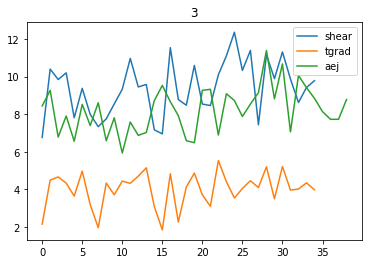

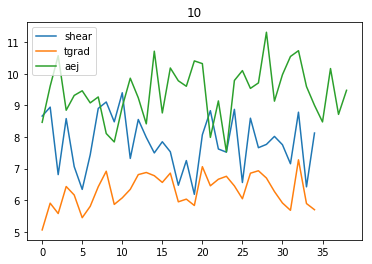

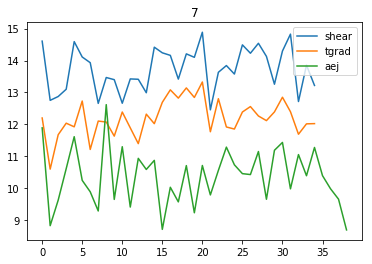

In [120]:
monthdic= calc_month(3)
monthdic2 = calc_month(10)
monthdic3 = calc_month(7)

Mean tgrad -1.40062
mean shear 6.2009363
Not significant
linear regression for mcs cover 1 (nan, 1.0)
Mean tgrad 0.9262495
mean shear 7.6717486
linear regression for mcs cover 2 (-0.6639039404893431, 1.3739370459151952e-05)
Mean tgrad 3.9986067
mean shear 9.3911085
linear regression for mcs cover 3 (-0.4531798915000861, 0.006258859407815032)
Mean tgrad 6.5221915
mean shear 11.395988
linear regression for mcs cover 4 (-0.5135920599930677, 0.001602136346984386)
Mean tgrad 8.746471
mean shear 12.492584
linear regression for mcs cover 5 (-0.6034223837939404, 0.00012442496801740813)
Mean tgrad 10.383164
mean shear 12.562422
linear regression for mcs cover 6 (-0.515327830911273, 0.0015348532819487815)
Mean tgrad 12.2029295
mean shear 13.727286
linear regression for mcs cover 7 (-0.5567196837906593, 0.0005141202433237804)
Mean tgrad 11.925942
mean shear 12.877889
linear regression for mcs cover 8 (-0.3305085482171596, 0.05247813059919849)
Mean tgrad 9.212869
mean shear 11.795824
linear regres

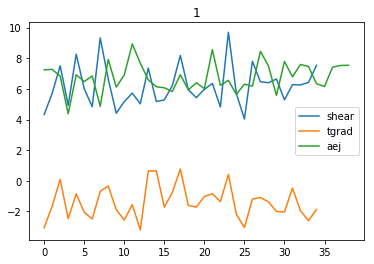

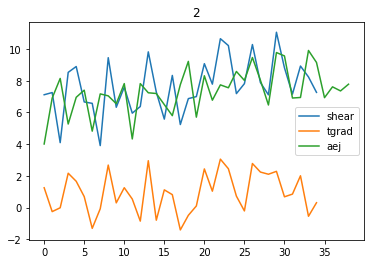

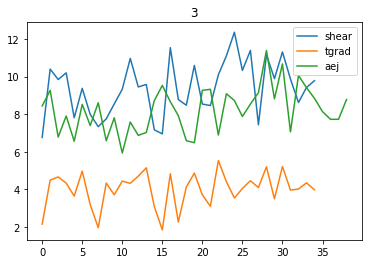

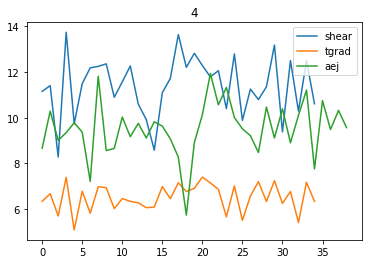

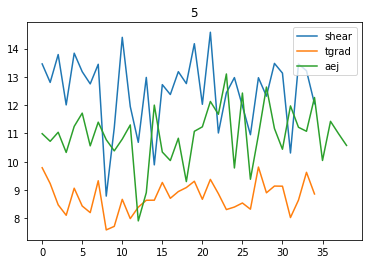

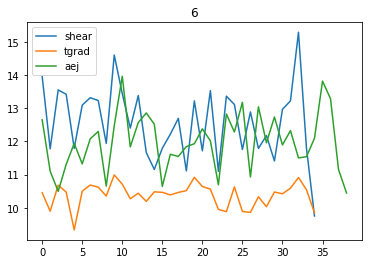

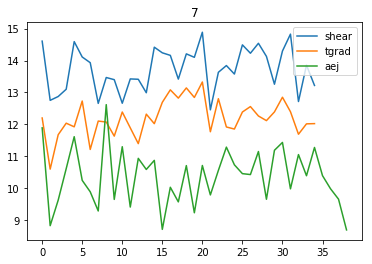

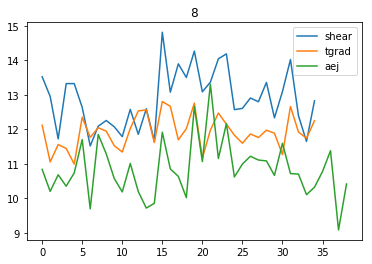

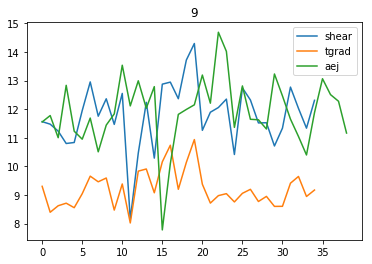

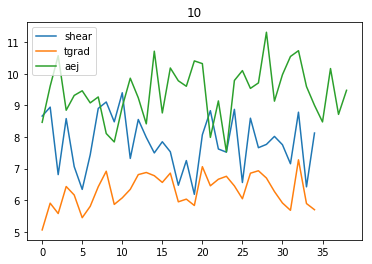

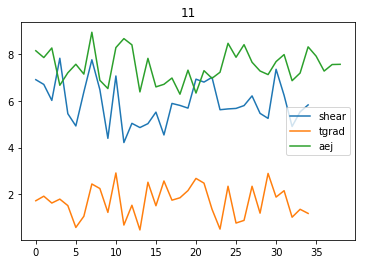

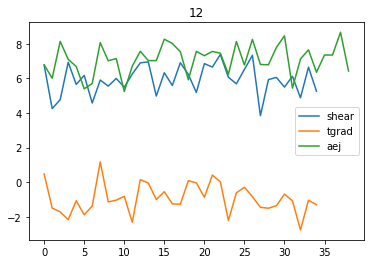

In [121]:
rlist = []
for mm in range(1,13):
    dic = calc_month(mm)
    rlist.append(dic[10][0])

In [112]:
rlist

[0.7564658,
 0.65249884,
 0.7025668,
 0.7763272,
 0.67742234,
 0.57075405,
 0.27678365,
 0.3880745,
 0.6570516,
 0.5975337,
 0.42824322,
 0.30117038]

In [122]:
rlist

[0.76050806,
 0.6489587,
 0.659234,
 0.80820847,
 0.68946946,
 0.59948325,
 0.34774423,
 0.4427291,
 0.76572806,
 0.6031855,
 0.40858975,
 0.28573728]

In [67]:
# shear and q correlate in march but MCS cooling explanation is dominated by shear
stats.pearsonr(monthdic[0].values[1::]-monthdic[0].values[0:-1],monthdic[11].values[1::]-monthdic[11].values[0:-1])

(0.5390638, 0.0010036149144188964)

In [68]:
#March: MCS temperature correlation with q, shear effect removed is low
u_stat.pcor(monthdic[11].values[1::]-monthdic[11].values[0:-1],
              monthdic[1].values[1::]-monthdic[1].values[0:-1],
             monthdic[0].values[1::]-monthdic[0].values[0:-1])

(0.03527310382684048, 0.8454900498000267)

In [69]:
#March: MCS temperature correlation with shear, q effect removed is high
u_stat.pcor(monthdic[0].values[1::]-monthdic[0].values[0:-1],
              monthdic[1].values[1::]-monthdic[1].values[0:-1],
             monthdic[11].values[1::]-monthdic[11].values[0:-1])

(-0.6046159117235234, 0.00019399556894027586)

In [70]:
# in october, shear and q do not correlate. 
stats.pearsonr(monthdic2[0].values[1::]-monthdic2[0].values[0:-1],monthdic2[11].values[1::]-monthdic2[11].values[0:-1])

(-0.002358652, 0.9894373118842572)

In [71]:
#October: MCS temperature correlation with q, shear effect removed is very high
u_stat.pcor(monthdic2[11].values[1::]-monthdic2[11].values[0:-1],
              monthdic2[1].values[1::]-monthdic2[1].values[0:-1],
             monthdic2[0].values[1::]-monthdic2[0].values[0:-1])

(-0.6905600248858564, 8.679803099751463e-06)

In [72]:
# October: MCS temperature correlation with shear, q effect removed is low
u_stat.pcor(monthdic2[0].values[1::]-monthdic2[0].values[0:-1],
              monthdic2[1].values[1::]-monthdic2[1].values[0:-1],
             monthdic2[11].values[1::]-monthdic2[11].values[0:-1])

(0.1588470672538936, 0.37726486519920144)

In [73]:
monthdic[7]

<xarray.DataArray 't2m' (time: 35)>
array([2.138855, 4.488892, 4.656525, 4.326843, 3.634247, 4.963287, 3.179016,
       1.948456, 4.330688, 3.703278, 4.433899, 4.312714, 4.69751 , 5.139526,
       3.082581, 2.437286, 4.825378, 2.252594, 4.122467, 4.860168, 3.701019,
       3.092834, 5.531128, 4.404266, 3.532623, 4.041107, 4.45517 , 4.089722,
       5.196075, 3.489502, 5.210571, 3.955017, 4.01123 , 4.34082 , 3.970642],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1983-03-01 1984-03-01 ... 2017-03-01
    year     (time) int64 1983 1984 1985 1986 1987 ... 2013 2014 2015 2016 2017

In [74]:
strend_ns.transpose().shape

(34, 12)

In [75]:
contour = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : strend_ns.transpose().values,  # /shearmean.transpose().values)*100
           'levels' : [-0.6,-0.4,-0.2,0.2,0.4, 0.6] , 'cmap' : 'viridis', 'colors' : 'k'} #  [-0.5,-0.3,-0.1,0.1,0.3,0.5] np.array([-14,-8,-2,2,8,14])

contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : shearmean.transpose(), 
           'levels' : np.linspace(np.min(shearmean),np.max(shearmean),6), 'cmap' : 'Greys', 'colors' : 'k'} #np.array([-0.75, -0.6, -0.45])*-1

mask_sig = (qtrend.transpose()>0.1).astype(int) 

mask_sig2 = (strend_ns.transpose()>0.3).astype(int) 
#mask_sig2 = (strend_ns.transpose()>0.1).astype(int) 

In [76]:
monthdic[1]

<xarray.DataArray 'tir' (time: 35)>
array([-64.238327, -66.285507, -67.534348, -64.727005, -63.657665, -64.750427,
       -64.440224, -64.953491, -65.452194, -64.35099 , -65.85688 , -66.065308,
       -65.406715, -65.51899 , -65.705627, -64.890274, -67.713234, -66.166779,
       -65.222321, -66.442795, -63.630302, -64.652199, -66.886497, -65.854836,
       -67.891655, -68.730057, -67.456787, -64.11998 , -66.965042, -64.923042,
       -67.254227, -68.01915 , -66.609154, -66.544617, -66.588676])
Coordinates:
  * time     (time) datetime64[ns] 1983-03-31 1984-03-31 ... 2017-03-31

/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Mean tgrad <xarray.DataArray 't2m' ()>
array(4.015884, dtype=float32)
linear regression for mcs cover 3 (-0.4531798915000861, 0.006258859407815032)
Mean tgrad <xarray.DataArray 't2m' ()>
array(6.294536, dtype=float32)
linear regression for mcs cover 10 (-0.7065787899354314, 2.1000329312109594e-06)


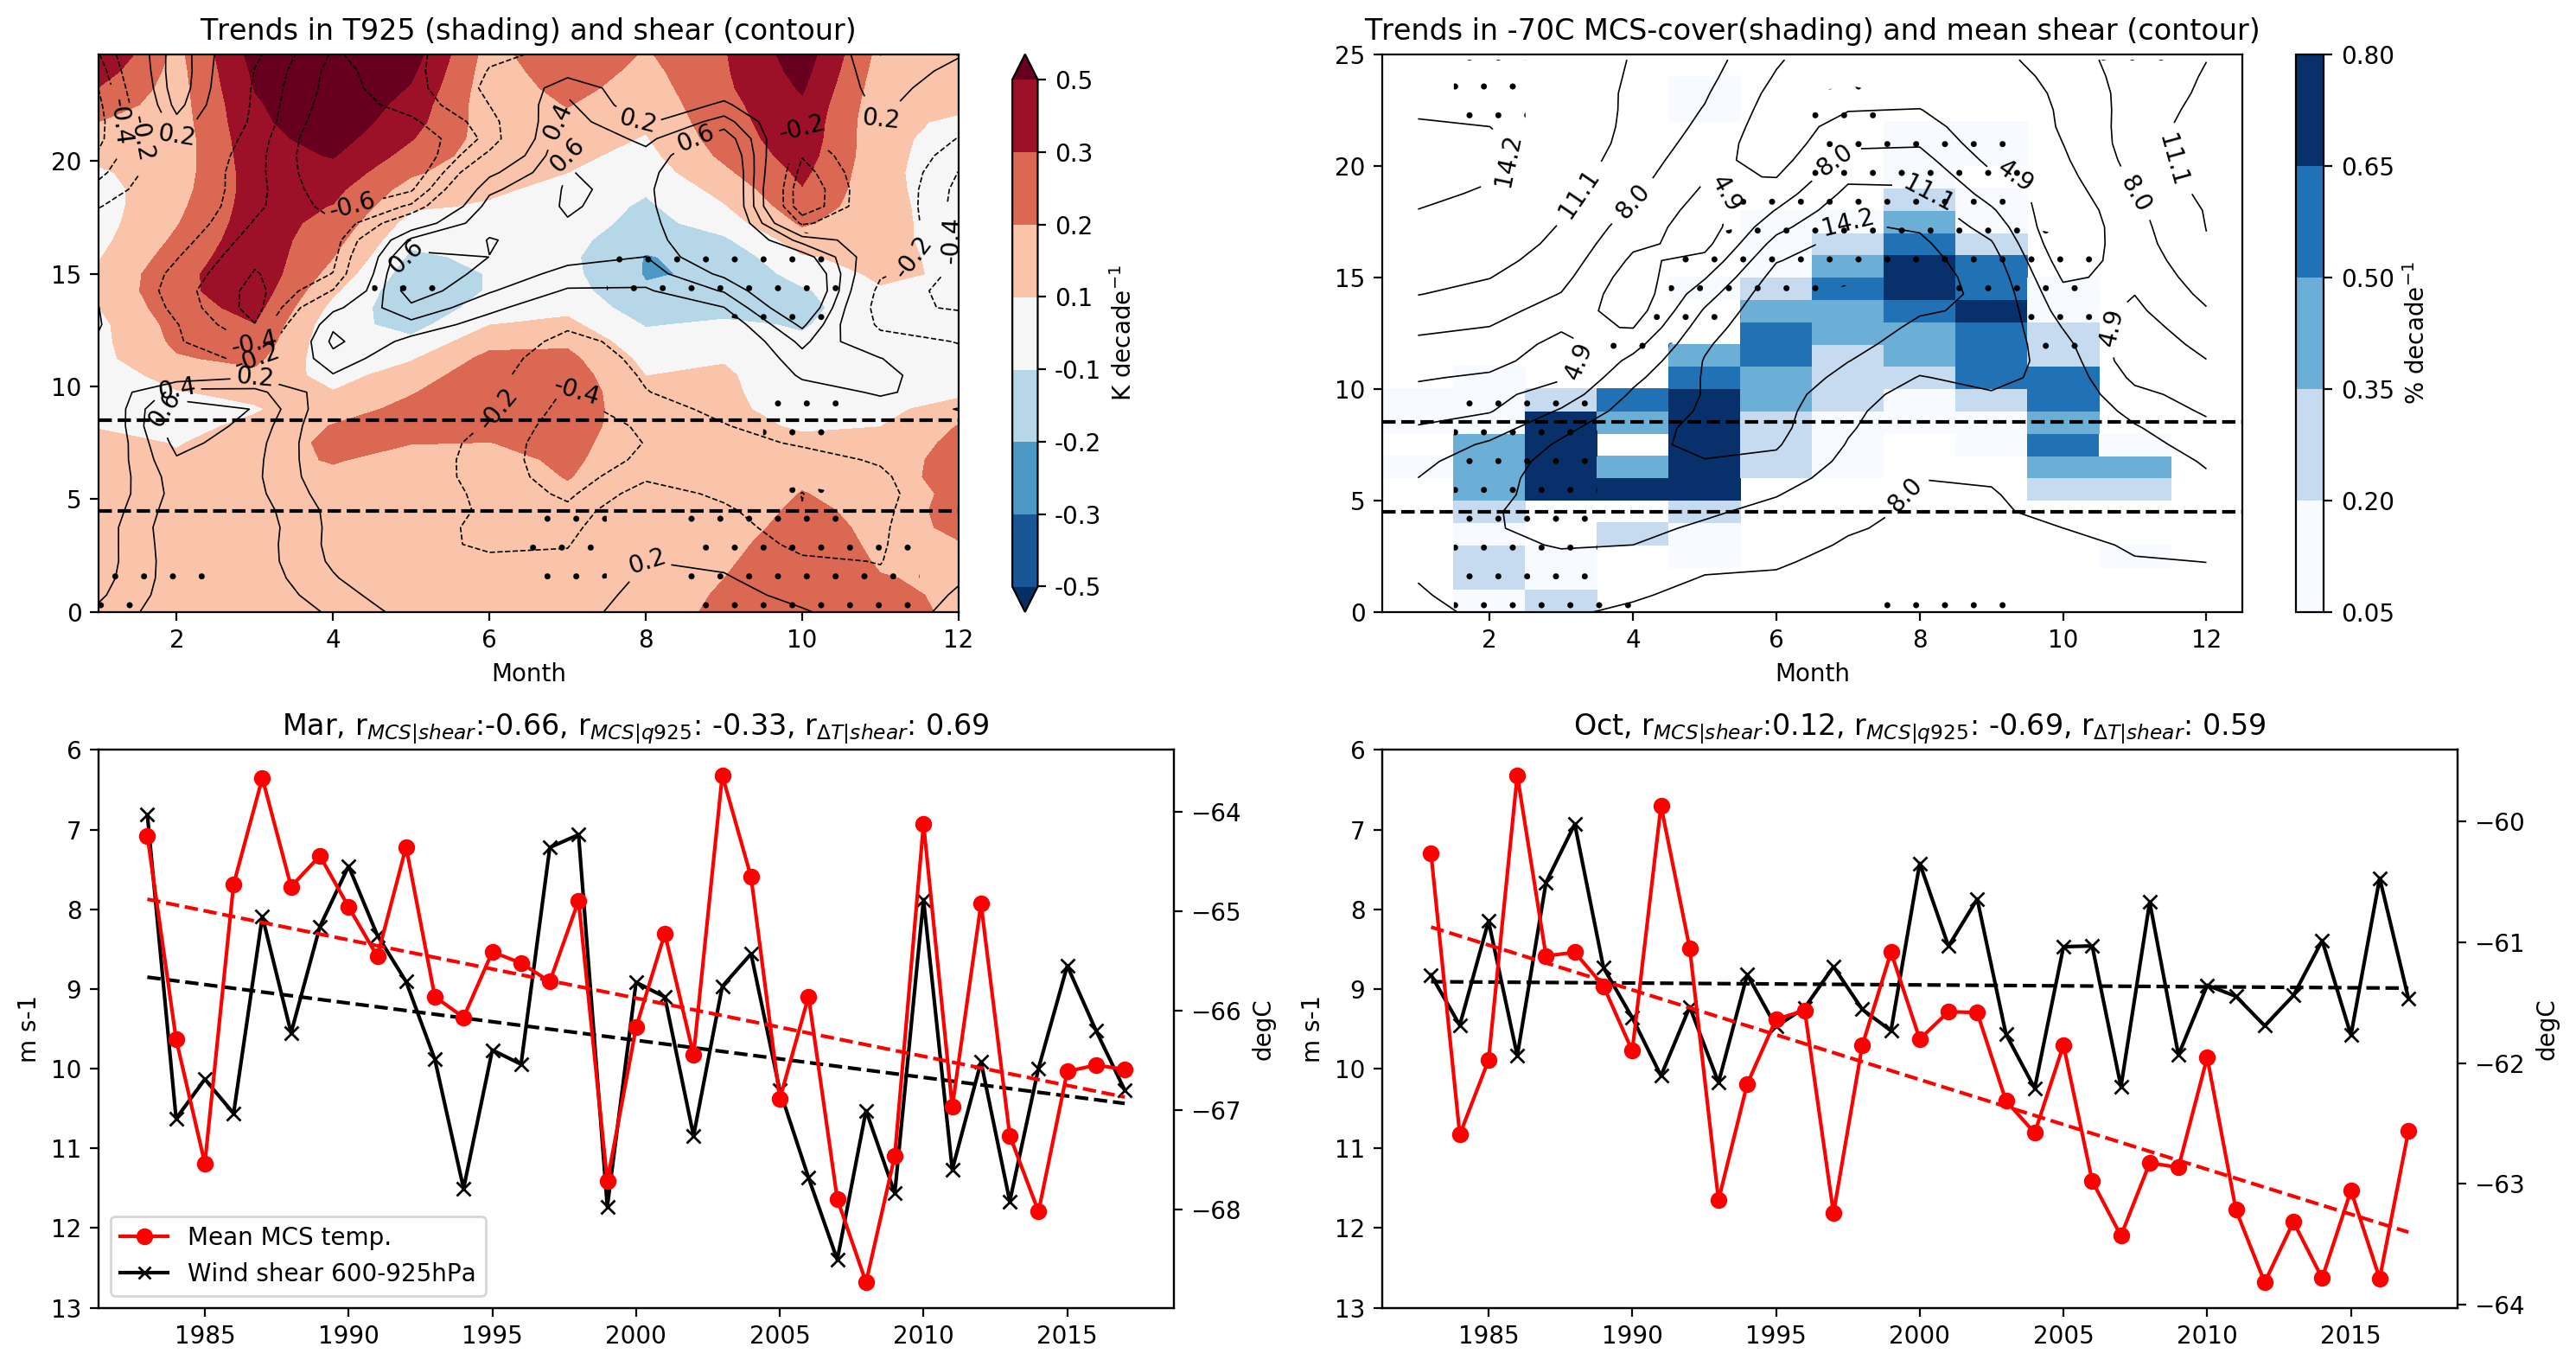

In [79]:
f=plt.figure(figsize=(15,8), dpi=200)  # this opens a plot window


left, width = 0.061, 0.25
bottom, height = 0.11, 0.52
bottom_h = bottom+height#+0.01

rect_scatter1 = [left, bottom, width, height]
rect_scatter2 = [left+width+left, bottom, width, height]
rect_scatter3 = [3*left+2*width, bottom, width, height]

rect_histx1 = [left, bottom_h, width, 0.33]
rect_histx2 = [left+width+left, bottom_h, width, 0.33]
rect_histx3 = [3*left+2*width, bottom_h, width-0.0185, 0.33]


ax = f.add_subplot(221) #plt.axes(rect_histx1) #  # this opens a new plot axis
mapp = ax.contourf(ttrend.month, era_trend.latitude, ttrend.transpose(), 
                   cmap='RdBu_r', extend='both', levels=np.linspace(-0.45,0.45,8))  # this is the actual plot


mpl.rcParams['hatch.linewidth'] = 0.1

## mask for significance indicator
if mask_sig is not None:
     plt.contourf(ttrend.month, era_trend.latitude, mask_sig, colors='none', hatches='..',
                 levels=[0.5, 1], linewidth=0.1)  
        
        
## additional contour on plot   
# if contour is not None:
#     cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
#                     cmap=contour['cmap'] ) 

#    plt.clabel(cs, inline=1, fontsize=10)

## additional contour on plot   
if contour is not None:
    cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
                    colors=contour['colors'] , linewidths=0.6) 

    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f") #"%d"

plt.title('Trends in T925 (shading) and shear (contour)')

plt.hlines(4.5,1,12, linestyles='dashed', color='k')
plt.hlines(8.5,1,12, linestyles='dashed', color='k')
plt.xlabel('Month')
# Countries
cbar = plt.colorbar(mapp, format="%1.1f")  # adds colorbar
cbar.set_label( 'K decade$^{-1}$')

###############################

ax = f.add_subplot(222)#plt.axes(rect_histx2)#f.add_subplot(222)  # this opens a new plot axis

cmapp = uplot.discrete_cmap(5, base_cmap='Blues')
#mapp = ax.contour(ttrend.month, era_trend.latitude, tmean.transpose()-273.15, 
#                  cmap='Reds', extend='both', levels=np.linspace(20,35,4), linestyles='dotted')  # this is the actual plot
#plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")


mappable = plt.pcolormesh(np.arange(0.5,13,1), np.arange(0,26,1),da.sel(lat=slice(0,25)).values
                          ,cmap=cmapp, vmin=0.05, vmax=0.80)

cbar = f.colorbar(mappable, ticks=np.linspace(0.05,0.80,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('% decade$^{-1}$')
plt.hlines(4.5,0.5,12.5, linestyles='dashed')
plt.hlines(8.5,0.5,12.5, linestyles='dashed')
plt.xlabel('Month')

plt.contourf(ttrend.month, era_trend.latitude, mask_sig2, colors='none', hatches='.',
                 levels=[0.5, 1], linewidth=0.05)

plt.title('Trends in -70C MCS-cover(shading) and mean shear (contour)')

#ipdb.set_trace()
# cs = ax.contour(np.arange(0.5,12,1), np.arange(0,25,1), mean.sel(lat=slice(0,25)), cmap='viridis' , levels=np.arange(0.5,4.5,1.5)) 
# plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

# mapp = ax.contour(ttrend.month, era_trend.latitude, umean.transpose(), 
#                    cmap='Reds', extend='both', levels=np.linspace(-10,-5,3), linestyles='dashed')  # this is the actual plot
# plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")

if contour2 is not None:
    cs = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], 
                    colors=contour2['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

################################

ax = f.add_subplot(223)  # this opens a new plot axis
m = 3
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[4][0]
ax.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
ax.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
ax.set_ylim(6,13)
ax.set_ylim(ax.get_ylim()[::-1])
ax1 = ax.twinx()
ax1.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax1.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax1.set_ylabel('degC')
ax.set_ylabel('m s-1')

ax.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2)) +', r$_{MCS|q925}$: ' 
             + str(np.round(monthdic[6][0], decimals=2)) + ', r$_{\Delta T|shear}$'': ' + str(np.round(monthdic[10][0], decimals=2)))
if m==3:
    ax.legend(handles=[mcsline, shearline], loc='lower left')
    
#################################

ax = f.add_subplot(224)  # this opens a new plot axis
m = 10
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[4][0]
ax.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
ax.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
#ax.set_ylim(-15,-5)

ax.set_ylim(6,13)
ax.set_ylim(ax.get_ylim()[::-1])

ax1 = ax.twinx()
ax1.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax1.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax1.set_ylabel('degC')
ax.set_ylabel('m s-1')


ax.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2)) +', r$_{MCS|q925}$: ' 
             + str(np.round(monthdic[6][0], decimals=2)) + ', r$_{\Delta T|shear}$'': ' + str(np.round(monthdic[10][0], decimals=2)))
if m==3:
    ax.legend(handles=[mcsline, shearline], loc='lower left')
    
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/fig1.jpg')

In [ ]:
contour = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : strend_ns.transpose().values,  # /shearmean.transpose().values)*100
           'levels' : [-0.6,-0.4,-0.2,0.2,0.4, 0.6] , 'cmap' : 'viridis', 'colors' : 'k'} #  [-0.5,-0.3,-0.1,0.1,0.3,0.5] np.array([-14,-8,-2,2,8,14])

contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : shearmean.transpose(), 
           'levels' : np.linspace(np.min(shearmean),np.max(shearmean),6), 'cmap' : 'Greys', 'colors' : 'k'} #np.array([-0.75, -0.6, -0.45])*-1

mask_sig = (qtrend.transpose()>0.1).astype(int) 

mask_sig2 = (strend_ns.transpose()>0.3).astype(int) 
#mask_sig2 = (strend_ns.transpose()>0.1).astype(int) 

/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Mean tgrad 3.9986067
mean shear 9.3911085
linear regression for mcs cover 3 (-0.4531798915000861, 0.006258859407815032)
Mean tgrad 6.293129
mean shear 7.83044
linear regression for mcs cover 10 (-0.7065787899354314, 2.1000329312109594e-06)


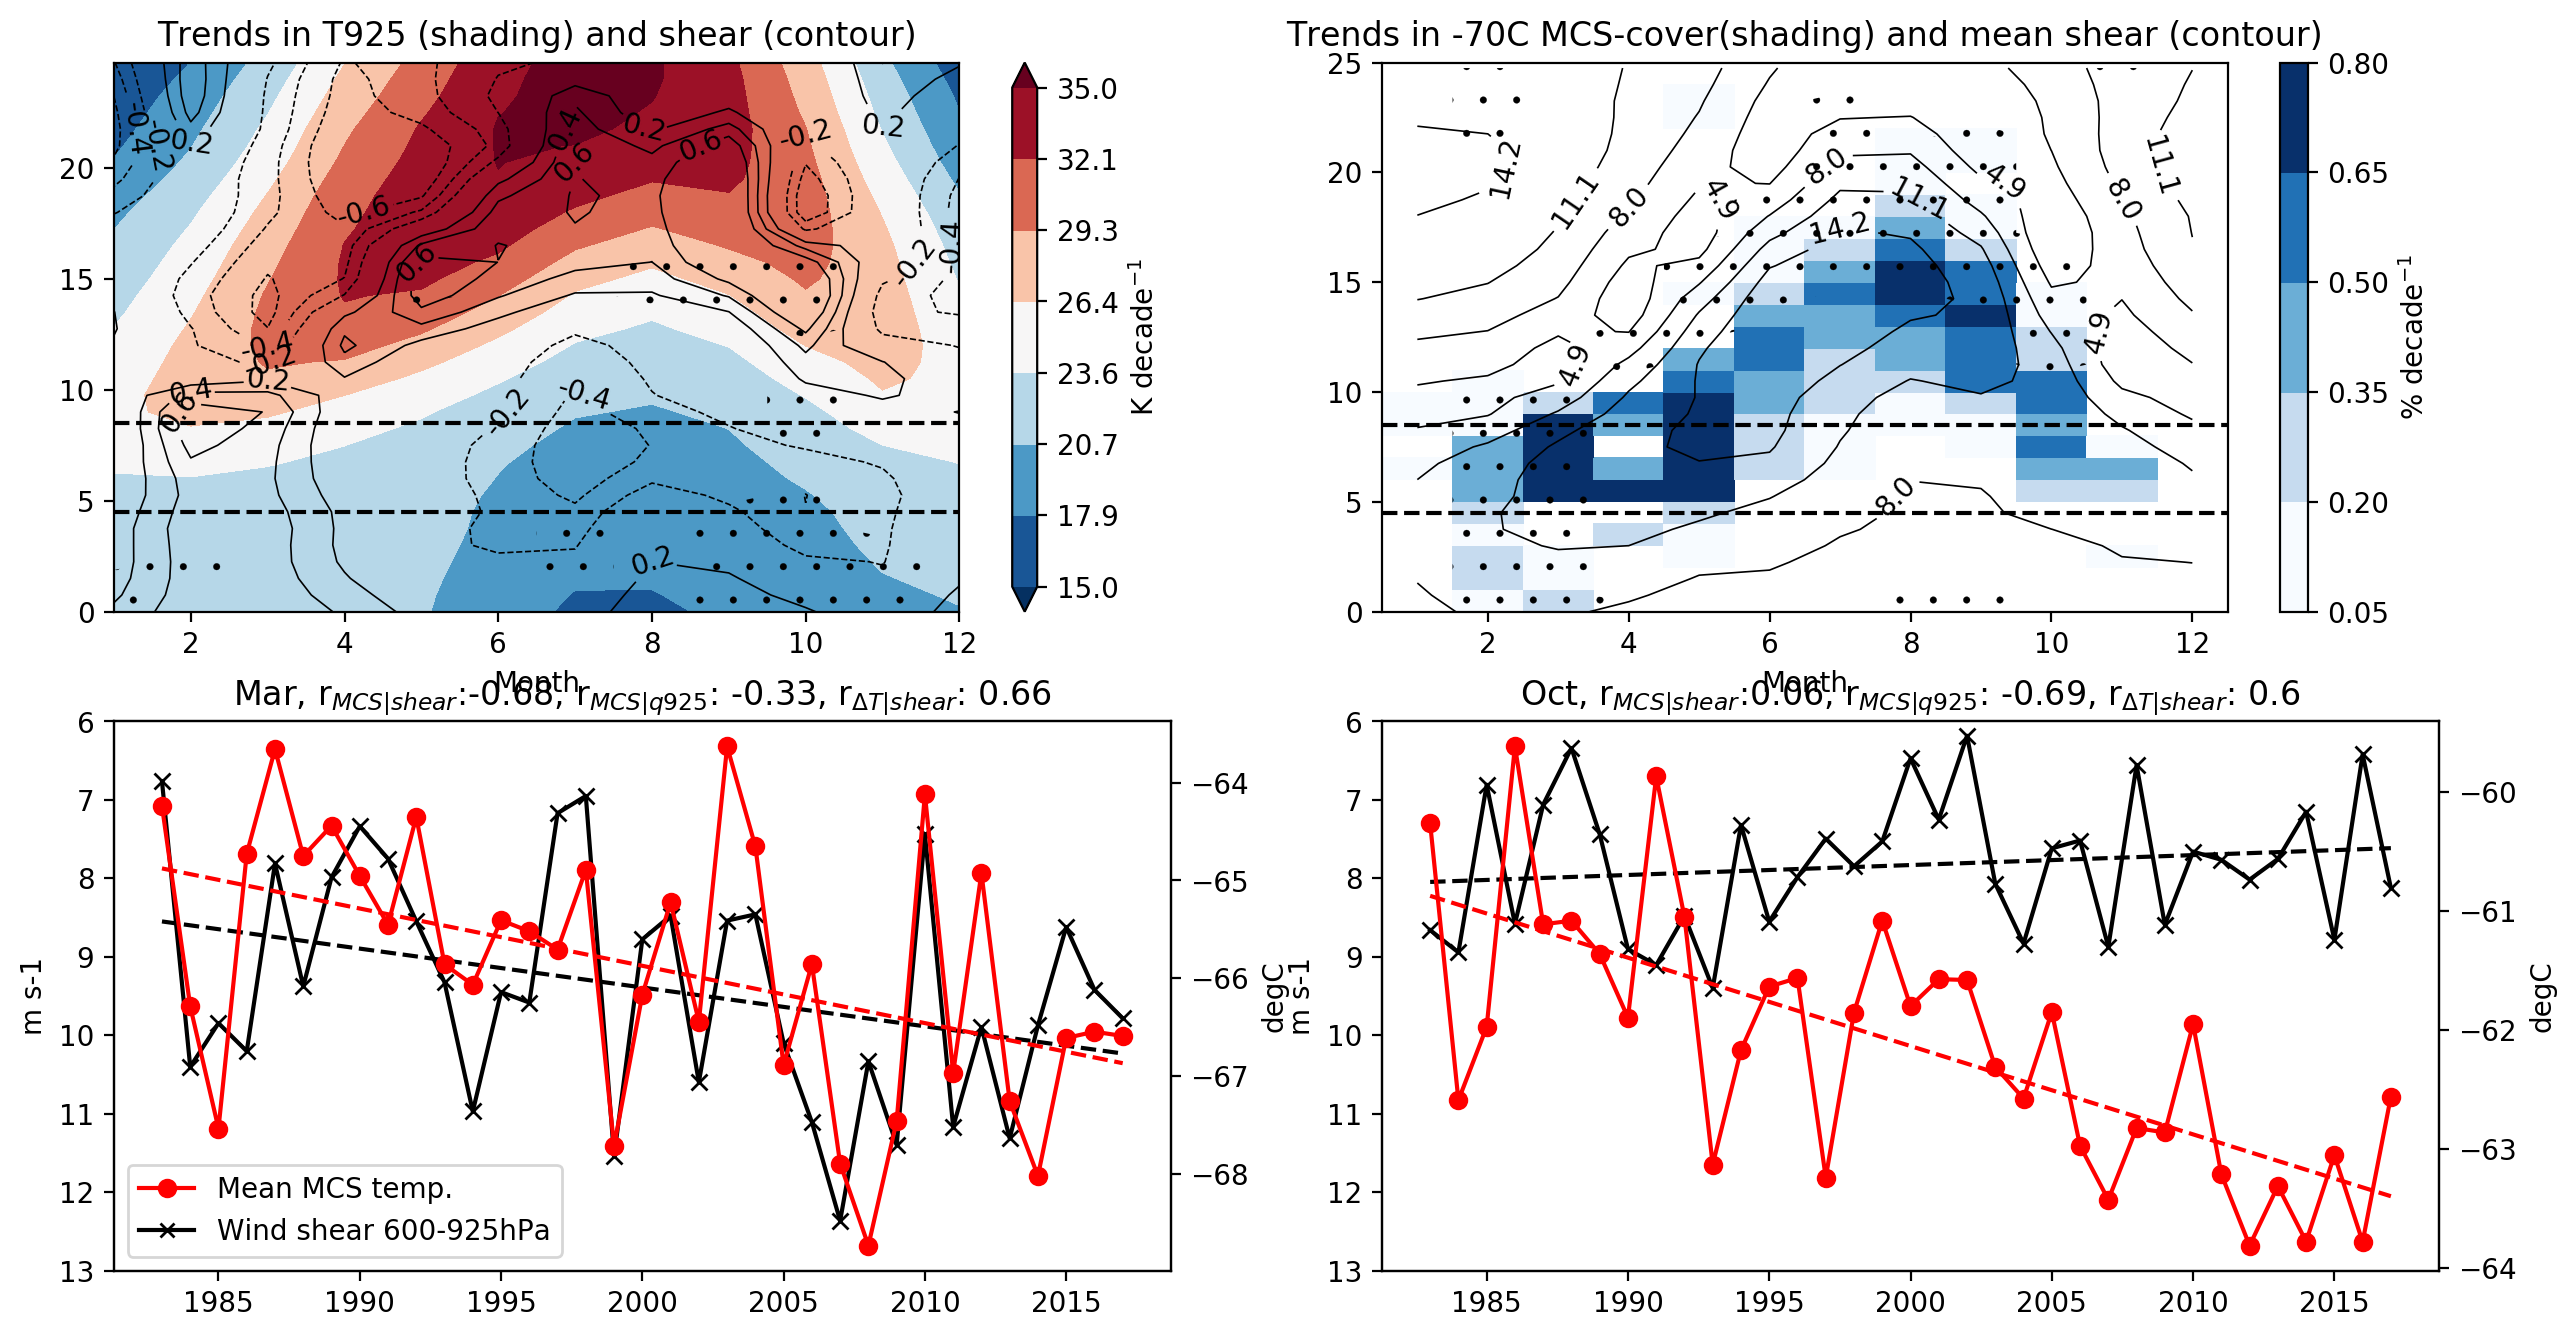

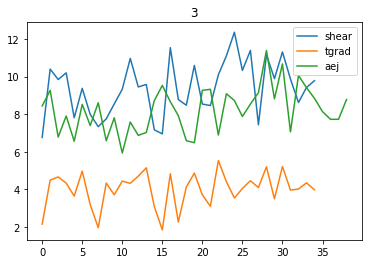

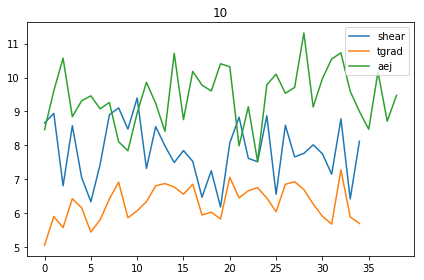

In [126]:
f=plt.figure(figsize=(15,8), dpi=200)  # this opens a plot window


left, width = 0.061, 0.25
bottom, height = 0.11, 0.52
bottom_h = bottom+height#+0.01

rect_scatter1 = [left, bottom, width, height]
rect_scatter2 = [left+width+left, bottom, width, height]
rect_scatter3 = [3*left+2*width, bottom, width, height]

rect_histx1 = [left, bottom_h, width, 0.33]
rect_histx2 = [left+width+left, bottom_h, width, 0.33]
rect_histx3 = [3*left+2*width, bottom_h, width-0.0185, 0.33]


ax = f.add_subplot(221) #plt.axes(rect_histx1) #  # this opens a new plot axis
mapp = ax.contourf(ttrend.month, era_trend.latitude, tmean.transpose()-273.15, 
                   cmap='RdBu_r', extend='both', levels=np.linspace(15,35,8))  # this is the actual plot


mpl.rcParams['hatch.linewidth'] = 0.1

## mask for significance indicator
if mask_sig is not None:
     plt.contourf(ttrend.month, era_trend.latitude, mask_sig, colors='none', hatches='..',
                 levels=[0.5, 1], linewidth=0.1)  
        
        
## additional contour on plot   
# if contour is not None:
#     cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
#                     cmap=contour['cmap'] ) 

#    plt.clabel(cs, inline=1, fontsize=10)

## additional contour on plot   
if contour2 is not None:
    cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
                    colors=contour['colors'] , linewidths=0.6) 

    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f") #"%d"

plt.title('Trends in T925 (shading) and shear (contour)')

plt.hlines(4.5,1,12, linestyles='dashed', color='k')
plt.hlines(8.5,1,12, linestyles='dashed', color='k')
plt.xlabel('Month')
# Countries
cbar = plt.colorbar(mapp, format="%1.1f")  # adds colorbar
cbar.set_label( 'K decade$^{-1}$')

###############################

ax = f.add_subplot(222)#plt.axes(rect_histx2)#f.add_subplot(222)  # this opens a new plot axis

cmapp = uplot.discrete_cmap(5, base_cmap='Blues')
#mapp = ax.contour(ttrend.month, era_trend.latitude, tmean.transpose()-273.15, 
#                  cmap='Reds', extend='both', levels=np.linspace(20,35,4), linestyles='dotted')  # this is the actual plot
#plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")


mappable = plt.pcolormesh(np.arange(0.5,13,1), np.arange(0,26,1),da.sel(lat=slice(0,25)).values
                          ,cmap=cmapp, vmin=0.05, vmax=0.80)

cbar = f.colorbar(mappable, ticks=np.linspace(0.05,0.80,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('% decade$^{-1}$')
plt.hlines(4.5,0.5,12.5, linestyles='dashed')
plt.hlines(8.5,0.5,12.5, linestyles='dashed')
plt.xlabel('Month')

plt.contourf(ttrend.month, era_trend.latitude, mask_sig2, colors='none', hatches='.',
                 levels=[0.5, 1], linewidth=0.05)

plt.title('Trends in -70C MCS-cover(shading) and mean shear (contour)')

#ipdb.set_trace()
# cs = ax.contour(np.arange(0.5,12,1), np.arange(0,25,1), mean.sel(lat=slice(0,25)), cmap='viridis' , levels=np.arange(0.5,4.5,1.5)) 
# plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

# mapp = ax.contour(ttrend.month, era_trend.latitude, umean.transpose(), 
#                    cmap='Reds', extend='both', levels=np.linspace(-10,-5,3), linestyles='dashed')  # this is the actual plot
# plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")

if contour2 is not None:
    cs = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], 
                    colors=contour2['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

################################

ax = f.add_subplot(223)  # this opens a new plot axis
m = 3
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[4][0]
ax.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
ax.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
ax.set_ylim(6,13)
ax.set_ylim(ax.get_ylim()[::-1])
ax1 = ax.twinx()
ax1.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax1.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax1.set_ylabel('degC')
ax.set_ylabel('m s-1')

ax.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2)) +', r$_{MCS|q925}$: ' 
             + str(np.round(monthdic[6][0], decimals=2)) + ', r$_{\Delta T|shear}$'': ' + str(np.round(monthdic[10][0], decimals=2)))
if m==3:
    ax.legend(handles=[mcsline, shearline], loc='lower left')
    
#################################

ax = f.add_subplot(224)  # this opens a new plot axis
m = 10
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[4][0]
ax.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
ax.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
#ax.set_ylim(-15,-5)

ax.set_ylim(6,13)
ax.set_ylim(ax.get_ylim()[::-1])

ax1 = ax.twinx()
ax1.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax1.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax1.set_ylabel('degC')
ax.set_ylabel('m s-1')


ax.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2)) +', r$_{MCS|q925}$: ' 
             + str(np.round(monthdic[6][0], decimals=2)) + ', r$_{\Delta T|shear}$'': ' + str(np.round(monthdic[10][0], decimals=2)))
if m==3:
    ax.legend(handles=[mcsline, shearline], loc='lower left')
    
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/fig1.jpg')